# Hindi2Vec Language Modeling

The goal of this notebook is to train Hindi word embeddings using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182)--basically LSTM with dropouts--with data from [Wikipedia](https://dumps.wikimedia.org/hiwiki/latest/hiwiki-latest-pages-articles.xml.bz2) (pulled on March 2, 2018). 

We achieved perplexity of XX with YY embeddings, compared to [state-of-the-art on November 17, 2017](https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems) at 40.68 for English language. To the best of our knowledge, there is no comparable research in Hindi language at the point of writing (March 2, 2018).

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import dill as pickle
import json
from IPython.display import Image
from IPython.core.display import HTML

from spacy.lang.hi import *

import re
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

In [2]:
from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

In [3]:
PATH='C:\\Users\\nirantk\\Desktop\\hindi-wiki\\'
# path to the xml wikipedia dump

EXT_PATH = 'extract\\'
TRN_PATH = 'train\\'
VAL_PATH = 'valid\\'
SAMPLE_PATH = 'sample\\'

EXT = f'{PATH}{EXT_PATH}'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
SAMPLE = f'{PATH}{SAMPLE_PATH}'

ext_files = !ls {EXT}
sample_files = !ls {SAMPLE}

## Text Cleaning

In [4]:
# Exact command line statement used to extract content from xml file
# !python wikiextractor/WikiExtractor.py hiwiki-latest-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude

### Save as Plain Text

In [ ]:
%%time
%%prun


def clean_files(extracted_filelist, TRN):    
    cleaned_all = []
    for ext_file in extracted_filelist:
        input_file = f'{EXT}{ext_file}'
        with open(input_file,'r', encoding='utf-8') as f:
            raw_txt = f.readlines()
            cleaned_doc = []
            for line in raw_txt:
                new_line = re.sub('<[^<]+?>', '', line)
                new_line = re.sub('__[^<]+?__', '', new_line) 
                new_line = new_line.strip()
                if new_line != '':
                    cleaned_doc.append(new_line)

            new_doc = "\n".join(cleaned_doc)
            cleaned_all.append(new_doc)
            with open(f"{TRN}{ext_file}.txt", "w", encoding='utf-8') as text_file:
                text_file.write(new_doc)
    return cleaned_all

cleaned_all = clean_files(ext_files, TRN)

In [ ]:
print(f'Preview:\n{cleaned_all[0][:500]}\n\nLength of list (should be equal to number of documents): {len(cleaned_all)}')

### Create Validation Set

In [ ]:
import random

random.shuffle(trn_files)
len_valid = int(0.2 * len(trn_files)) 
val_files = trn_files[:len_valid]
trn_files = trn_files[len_valid:]

In [ ]:
# # WARNING: Run exactly ONCE

# import shutil, os
# for root, dirs, files in os.walk(TRN):
#     for file in files:
#         if file.endswith(".txt") & (file in val_files):
#             shutil.move(os.path.join(root, file),VAL)

In [5]:
trn_files = !ls {TRN}
val_files = !ls {VAL}
print(trn_files), print(val_files), print(len(trn_files)), print(len(val_files))

['wiki_00.txt', 'wiki_01.txt', 'wiki_04.txt', 'wiki_05.txt', 'wiki_06.txt', 'wiki_07.txt', 'wiki_08.txt', 'wiki_11.txt', 'wiki_12.txt', 'wiki_13.txt', 'wiki_14.txt', 'wiki_15.txt', 'wiki_16.txt', 'wiki_17.txt', 'wiki_19.txt', 'wiki_20.txt', 'wiki_21.txt', 'wiki_22.txt', 'wiki_24.txt', 'wiki_25.txt', 'wiki_26.txt', 'wiki_28.txt', 'wiki_29.txt', 'wiki_30.txt', 'wiki_31.txt', 'wiki_32.txt', 'wiki_33.txt', 'wiki_34.txt', 'wiki_35.txt', 'wiki_36.txt']
['wiki_02.txt', 'wiki_03.txt', 'wiki_10.txt', 'wiki_23.txt']
30
4


(None, None, None, None)

## Text Processing

### Tokenizer

In [6]:
def word_tokenize(document):
    nlp = Hindi() # from spacy.lang.hi
    return [token.text for token in nlp(document)]
    
def docs_tokenize(documents_as_lists):   
    for document in documents_as_lists:
        tokens = word_tokenize(document)
        tokens_list.extend(tokens)
    
    return tokens_list

In [7]:
%%time
tokens_filename = "tokens_list.txt"
tokens_list = []

#TODO refactor from try except blocks to if else with if statement checking if file exists using Pathlib

try:
    print(f'Reading from {tokens_filename}')
    with open(tokens_filename, "r") as f:
         tokens_list = json.load(f)
    
except FileNotFoundError:
    print(f'FileNotFound. Trying to tokenize from cleaned_all')
    tokens_list = docs_tokenize(cleaned_all)
    
    with open('tokens_list.txt', 'w') as outfile:
        json.dump(tokens_list, outfile)

print(f'Found {len(tokens_list)} tokens') # 30598557 tokens expected

Reading from tokens_list.txt
Found 30598557 tokens
Wall time: 16 s


### Min Count

In [ ]:
# TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
# freqs = pd.DataFrame.from_dict(TEXT.vocab.freqs,orient='index')
# freqs.sort_values(0,ascending=False).head(10)

In [ ]:
# cnt = []
# for i in range(49):
#     row_cnt = freqs[freqs[0]>=i+1].shape[0]
#     cnt.append(row_cnt)

In [ ]:
# plt.plot(cnt)
# plt.axvline(x=10,color='red', linestyle='--')

In [ ]:
# #number of legitimate thai words at freqs
# freqs[freqs[0]<=10].sort_values(ascending=False,by=0).head(10)

### Data Loader

In [8]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled

In [9]:
TEXT = data.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=16
#backprop through time
bptt=70

In [10]:
#FILES = dict(train=f'{SAMPLE_PATH}', validation=f'{SAMPLE_PATH}', test=f'{SAMPLE_PATH}')
FILES = dict(train=f'{TRN_PATH}', validation=f'{VAL_PATH}', test=f'{SAMPLE_PATH}')

In [11]:
%%time
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=50)

Wall time: 21min 20s


In [12]:
%%time
pickle.dump(TEXT, open(f'{PATH}//models//TEXT_min_freq50.pkl','wb'))

Wall time: 751 ms


In [13]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

Variable containing:
  430
 1862
 4871
 1559
 1007
 1559
 1007
  565
  589
  202
[torch.cuda.LongTensor of size 10x1 (GPU 0)]

## Language Model

### Training

In [14]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [15]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|█████████████████████████████████████████████████▌               | 16635/21791 [20:59<06:30, 13.21it/s, loss=18.8]

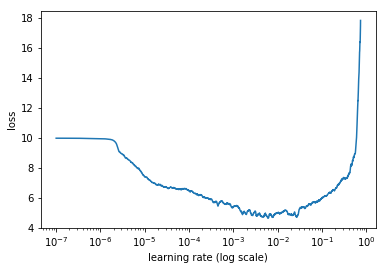

 76%|█████████████████████████████████████████████████▌               | 16635/21791 [21:10<06:33, 13.10it/s, loss=18.8]

In [17]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)
learner.sched.plot()

In [ ]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
learner.save_encoder('adam1_enc')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|                                                                    | 12/21791 [00:00<29:47, 12.19it/s, loss=9.99]


Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      5.371777   5.243932  
    1      4.339965   4.741244                                                                                         
    2      4.437619   4.622295                                                                                         
    3      4.05479    4.533704                                                                                         
    4      4.007942   4.438206                                                                                         
    5      3.997428   4.379419                                                                                         
    6      4.074864   4.318187                                                                                         
    7      3.923672   4.335486                                                                                         
    8  

In [19]:
learner.save_encoder('adam1_enc')

In [23]:
#loss 3.84171; perplexity 46.61
learner.fit(1e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')
#learner.save_encoder('adam3_enc')

In [22]:
learner.save_encoder('adam3_hindi_minfreq10_enc_v2')

In [24]:
learner.fit(1e-3, 1, wds=1e-6, cycle_len=5, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      3.50012    4.0503    
    1      3.489653   4.020124                                                                                         
    2      3.498954   3.959882                                                                                         
    3      3.501738   3.891938                                                                                         
    4      3.602018   3.846254                                                                                         



[3.846254]

In [25]:
learner.save_encoder('adam3_20')

# Testing Results

In [ ]:
#m = learner.model
#pickle.dump(m,open(f'{PATH}models/wiki_lang.pkl','wb'))
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
m = pickle.load(open(f'{PATH}models/wiki_lang.pkl','rb'))
m[0].bs=1
m.eval()

In [ ]:
def gen_text(ss,topk):
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [TEXT.vocab.itos[o] for o in to_np(pred_i)]

def gen_sentences(ss,nb_words):
    result = []
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        result.append(TEXT.vocab.itos[pred_i.data[0]])
        pred,*_ = m(pred_i[0].unsqueeze(0))
    return(result)

In [ ]:
ss="""สวัสดีครับพี่น้องเสื้อ"""
gen_text(ss,10)

In [ ]:
''.join(gen_sentences(ss,50))

## Embeddings

### Extract

In [ ]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
TEXT.vocab.set_vectors(vectors=emb_weights.data,dim=300,stoi=TEXT.vocab.stoi)
#pickle.dump(TEXT, open(f'{PATH}models/TEXT_vec.pkl','wb'))

In [ ]:
TEXT_vec = pickle.load(open(f'{PATH}models/TEXT_vec.pkl','rb'))

In [ ]:
thai2vec = pd.DataFrame(to_np(TEXT_vec.vocab.vectors))
thai2vec.index = TEXT_vec.vocab.itos
thai2vec.head(10)

In [ ]:
thai2save = thai2vec[~thai2vec.index.str.contains(' ')]
#remove lines with weird characters due to bad segmentation
thai2save = thai2save.iloc[3:-48,:]
#thai2save.to_csv(f'{PATH}models/thai2vec.vec',sep=' ',header=False, line_terminator='\n')
#add NB_ROWS NB_COLS as header
thai2save.shape

In [ ]:
#model.save_word2vec_format(f'{PATH}models/thai2vec.vec',f'{PATH}models/thai2vec.vocab',False)